Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
score_name = "quality"
# score_name = "linear_score"
m_train_examples: int = 100
m_test_examples: int = 100
noise_scale = 0.87
position_penalty_scale = -0.7123


know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:
position_penalties = [position_penalty_scale * i for i in range(n_alternatives)]

position_penalties

[-0.0, -0.7123, -1.4246, -2.1369000000000002, -2.8492]

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    position_penalties=position_penalties,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    position_penalties=position_penalties,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,0,1,1754,0,2,6425,1,3,2780,0,4,2646,0
1,0,4390,0,1,2031,0,2,2692,1,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,1,1,6283,0,2,3610,0,3,2085,0,4,5610,0


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.48
1,pick_value_1,0.27
2,pick_value_2,0.14
3,pick_value_3,0.08
4,pick_value_4,0.03


In [18]:
# This is the data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,0,1754,0,6425,1,2780,0,2646,0
1,4390,0,2031,0,2692,1,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,1,2324,0,5815,0,1819,0,4567,0
4,2063,1,6283,0,3610,0,2085,0,5610,0
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,1,1374,0,312,0,926,0,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [19]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [20]:
observations_train_sorted = sort_observations_frame(observations_train)

In [21]:
observations_train_sorted.head(10)

,encoding_0,item_id_0,pick_value_0,encoding_1,item_id_1,pick_value_1,encoding_2,item_id_2,pick_value_2,encoding_3,item_id_3,pick_value_3,encoding_4,item_id_4,pick_value_4
0,2,6425,1,1,1754,0,0,1569,0,3,2780,0,4,2646,0
1,2,2692,1,1,2031,0,0,4390,0,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,1,1,6283,0,2,3610,0,3,2085,0,4,5610,0
5,0,2010,1,1,1465,0,2,6388,0,3,25,0,4,420,0
6,0,5903,1,1,1374,0,2,312,0,3,926,0,4,5467,0
7,0,5194,1,1,3651,0,2,1494,0,3,1749,0,4,5865,0
8,0,5946,1,1,4527,0,2,5988,0,3,3021,0,4,4821,0
9,0,6469,1,1,6044,0,2,2787,0,3,5786,0,4,3709,0


In [22]:
observations_train_sorted[
    [c for c in observations_train_sorted.columns if not c.startswith("pick_value_")]
].head(10)

,encoding_0,item_id_0,encoding_1,item_id_1,encoding_2,item_id_2,encoding_3,item_id_3,encoding_4,item_id_4
0,2,6425,1,1754,0,1569,3,2780,4,2646
1,2,2692,1,2031,0,4390,3,4416,4,1913
2,0,599,1,1808,2,64,3,59,4,1671
3,0,1392,1,2324,2,5815,3,1819,4,4567
4,0,2063,1,6283,2,3610,3,2085,4,5610
5,0,2010,1,1465,2,6388,3,25,4,420
6,0,5903,1,1374,2,312,3,926,4,5467
7,0,5194,1,3651,2,1494,3,1749,4,5865
8,0,5946,1,4527,2,5988,3,3021,4,4821
9,0,6469,1,6044,2,2787,3,5786,4,3709


In [23]:
assert np.all(observations_train_sorted["pick_value_0"] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_train_sorted[f"pick_value_{sel_i}"] == 0)

In [24]:
stan_model_panel_src = define_Stan_panel_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_panel_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [25]:
data_str = format_Stan_data(
    observations_sorted=observations_train_sorted,
    features_frame=features_frame,
)

In [26]:
fit = run_stan_model(
    stan_model_src=stan_model_panel_src,
    data_str=data_str,
)

In [27]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=["lp__"])

wt_frame

,lp__
0,-156.960
1,-154.708
2,-153.795
3,-140.419
4,-144.484
...,...
3995,-146.644
3996,-148.335
3997,-143.870
3998,-142.505


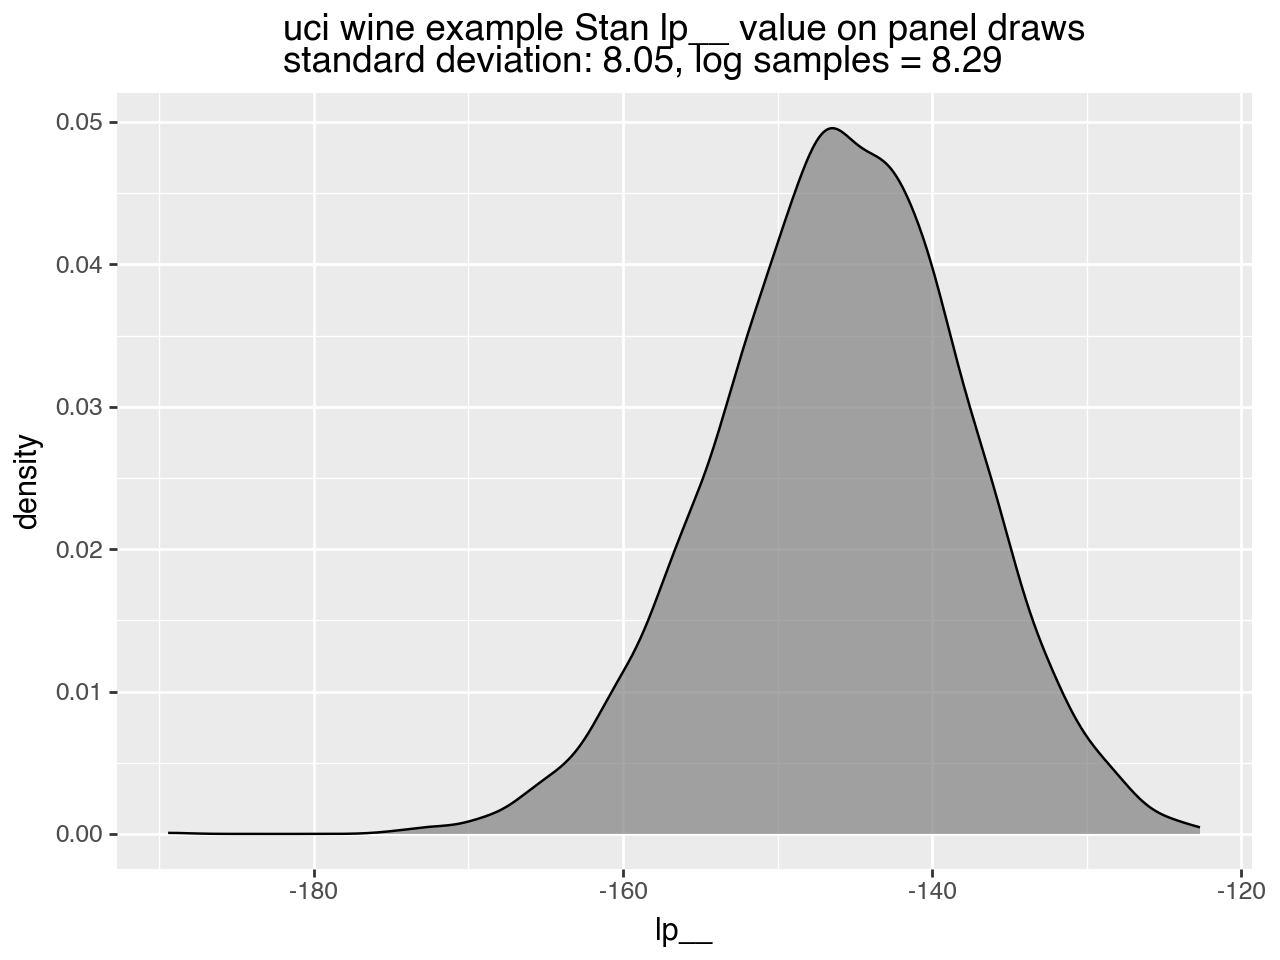

In [28]:
if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on panel draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [29]:
beta_draws = fit.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) + [
    f"position_effect_{sel_i}" for sel_i in range(n_alternatives)
]

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,density is white,pH is white,sulphates is white,alcohol is white,is_red,position_effect_0,position_effect_1,position_effect_2,position_effect_3,position_effect_4
0,0.316911,-2.92702,-8.423460,1.445520,11.70240,0.493259,-0.182151,-12.74640,-0.725895,10.47810,...,-27.752700,0.619534,1.219320,3.45560,6.866150,14.00870,9.881800,1.59701,-2.440800,-8.44764
1,1.213880,7.94176,0.813003,-1.255680,-13.76430,0.442091,-0.104090,5.67218,0.820607,-6.27145,...,22.975800,-13.737000,7.801980,6.10485,-1.521770,17.15740,8.576650,2.89536,2.107160,-4.08482
2,1.623210,10.80140,3.872680,-2.315360,6.84523,0.309119,-0.219951,-2.29985,-11.481100,4.35792,...,-15.684800,-6.852390,12.814500,5.77795,7.170580,17.40740,10.477900,7.46857,-0.272969,-3.96587
3,2.148880,3.91024,-14.469800,-0.954000,2.14505,0.213754,0.038294,-5.72506,1.834200,12.48670,...,-8.330640,0.547227,14.212800,6.27418,1.140050,17.83020,8.201060,5.59375,3.598860,-8.44602
4,1.050740,-5.47563,-8.299170,0.402523,-7.67813,0.133387,-0.140132,3.80197,-2.539560,6.81911,...,0.626566,2.611540,-8.968670,4.03730,0.131978,16.55640,8.834910,3.89920,0.539656,2.47690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2.363270,-5.65326,-8.052200,1.680070,-10.25900,0.384542,-0.110862,11.81250,-5.699760,3.43608,...,-14.557500,1.644650,1.464040,5.54080,-0.310445,16.32090,8.686720,4.65707,-0.785782,-6.53628
3996,4.143150,3.44397,-5.634160,-3.018800,6.26838,0.192996,-0.060068,-16.89410,-4.343820,13.73180,...,2.290060,-0.766856,6.201550,3.32668,-2.944300,13.57110,7.762440,2.35526,-1.843280,-4.91680
3997,1.969000,-9.50665,-15.257400,1.610150,-28.48820,0.153841,-0.087075,12.72940,-3.389410,1.05073,...,-5.751450,3.390170,-1.333760,4.02713,0.301844,15.26080,9.131090,3.53447,-1.133240,-13.24720
3998,0.559803,6.78282,2.463700,-2.577790,7.00093,0.040376,-0.155403,1.47785,4.551110,5.24369,...,5.040220,-4.213560,3.179970,4.90252,-0.828766,8.85834,3.089180,-4.52258,-6.250040,-9.76491


In [30]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
# estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan

fixed acidity is red              2.763103
volatile acidity is red           0.802193
citric acid is red              -12.287212
residual sugar is red            -1.120729
chlorides is red                 -1.239650
free sulfur dioxide is red        0.123669
total sulfur dioxide is red      -0.104074
density is red                    2.022827
pH is red                        -0.703296
sulphates is red                  7.597423
alcohol is red                    1.915353
fixed acidity is white           -1.600167
volatile acidity is white       -11.793476
citric acid is white             -0.961421
residual sugar is white           0.621423
chlorides is white               -0.506257
free sulfur dioxide is white      0.057670
total sulfur dioxide is white    -0.013159
density is white                 -1.913022
pH is white                       0.015105
sulphates is white                2.319921
alcohol is white                  4.746051
is_red                            2.321080
position_ef

estimated position influences


,position,estimated effect,actual effect
0,posn_0,0.000000,-0.0000
1,posn_1,-6.899184,-0.7123
2,posn_2,-11.382628,-1.4246
3,posn_3,-15.288032,-2.1369
4,posn_4,-20.180508,-2.8492


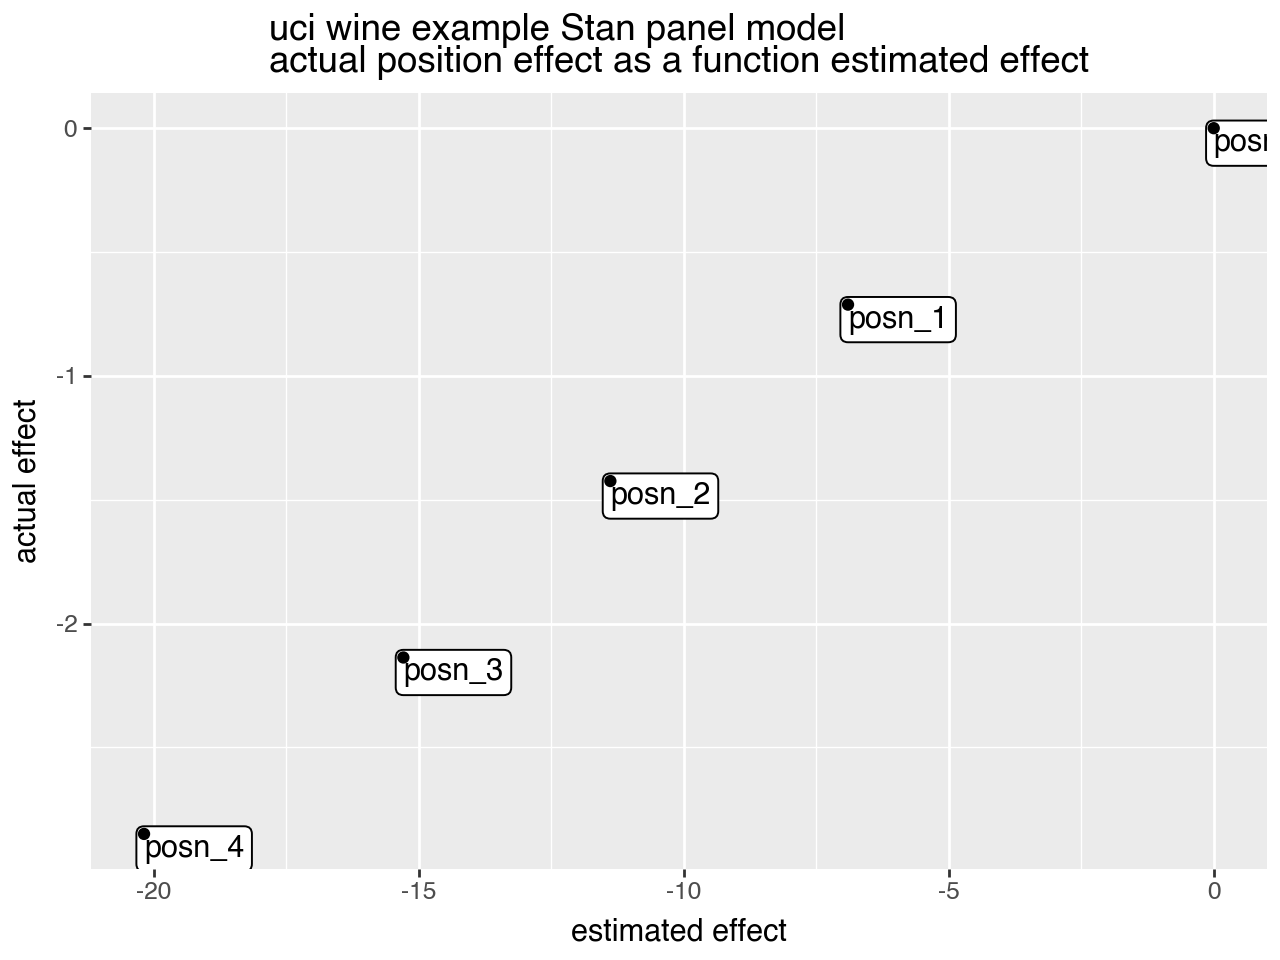

picks


,row,position,pick probability estimate,was pick
0,0,0,0.7297,True
1,0,1,0.0978,False
2,0,2,0.0539,False
3,0,3,0.0999,False
4,0,4,0.0187,False
5,1,0,0.4064,False
6,1,1,0.5025,True
7,1,2,0.0488,False
8,1,3,0.0379,False
9,1,4,0.0044,False


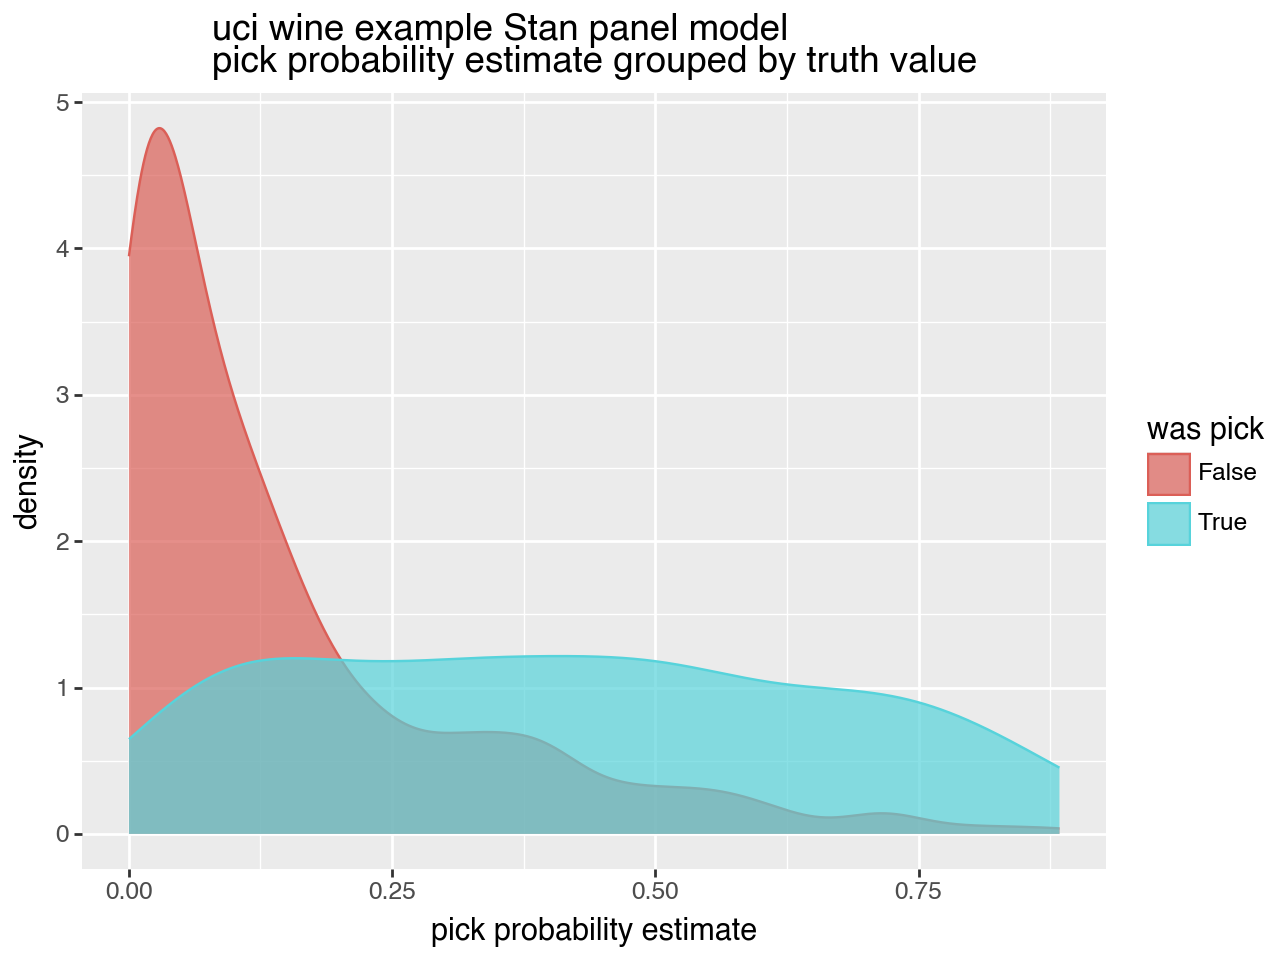

<Figure size 640x480 with 0 Axes>

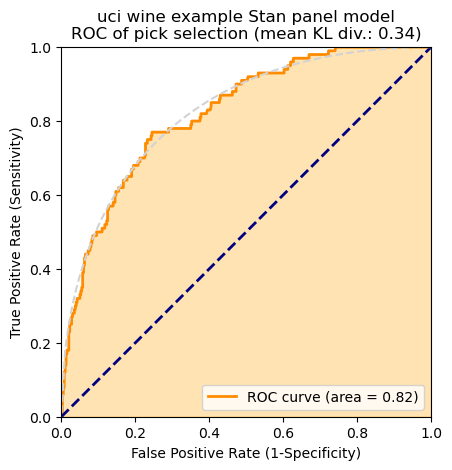

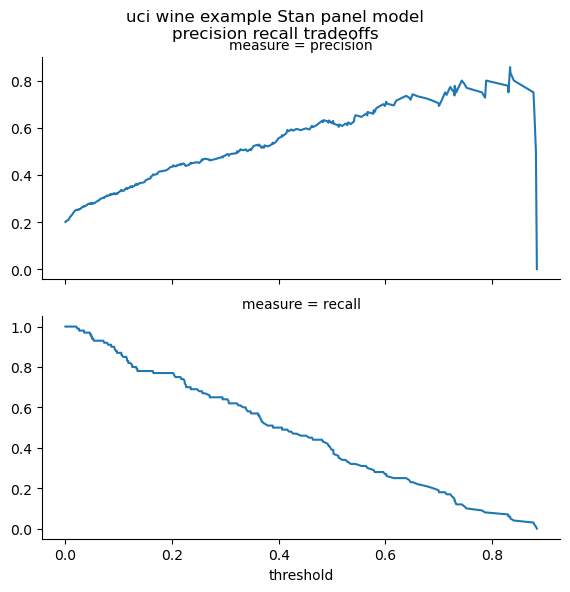

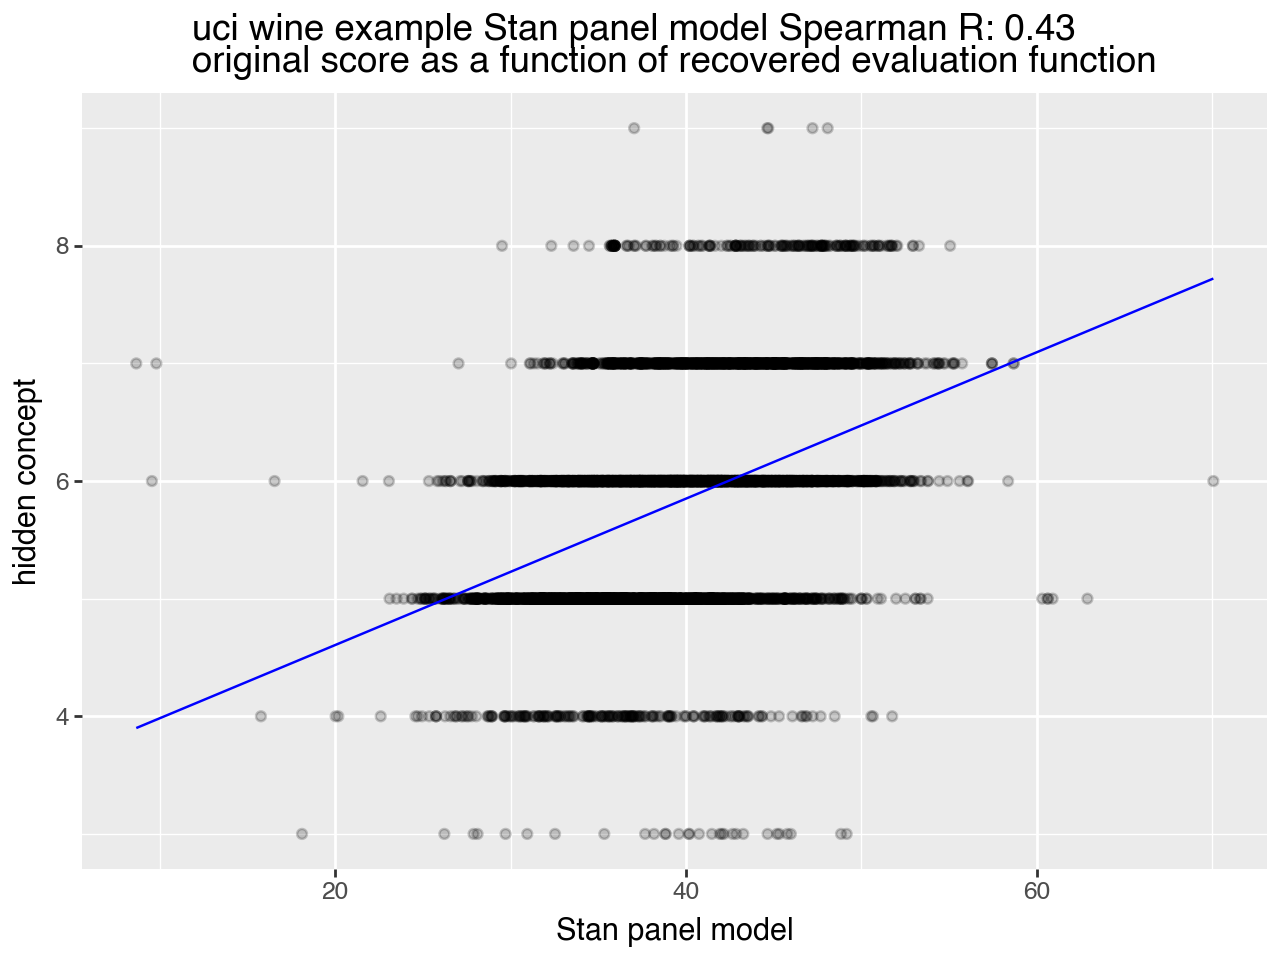

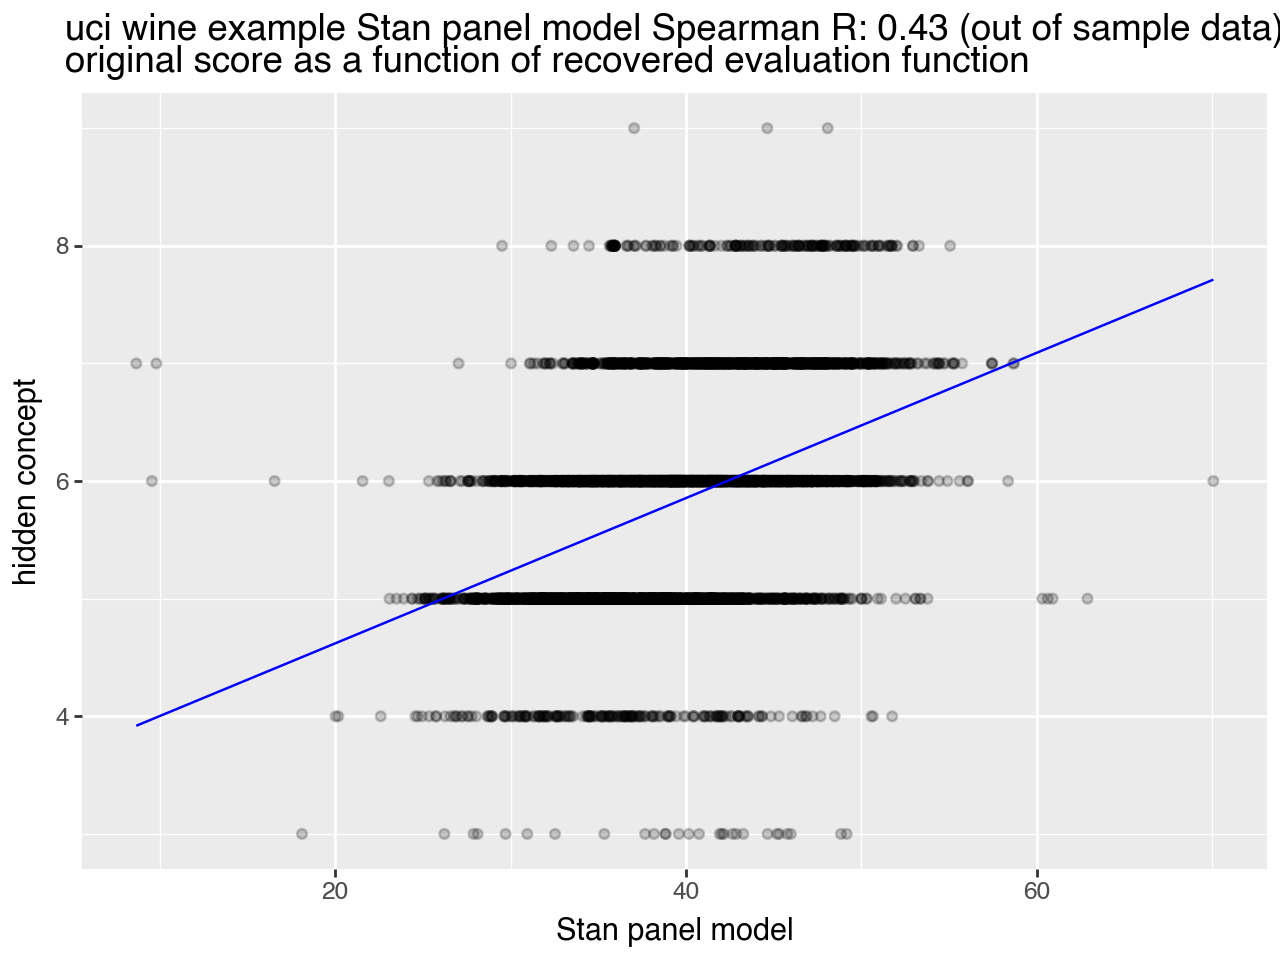

In [31]:
stat_pull = plot_rank_performance(
    model=estimated_beta_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan panel model",  # display name of estimate
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [32]:
encode_position: bool = True
feature_names = list(features_frame.columns)
sample_weight = None
if encode_position:
    feature_names = feature_names +[
        f"position_{sel_i}" for sel_i in range(n_alternatives)
    ]
else:
    sample_weight = []
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                )
            if encode_position:
                posn_vec = [0] * n_alternatives
                posn_vec[sel_pick] = 1.0
                posn_vec[sel_i] = -1.0
                encoded_row = encoded_row + posn_vec  
            if sample_weight is not None:
                # TODO: use sel_wt for conjugate row
                sample_weight.append(1.0 / win_frequencies.loc[sel_pick, 'win frequency'])
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [33]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classificaton_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classificaton_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classificaton_model_name = 'Random Forest'

In [34]:
if sample_weight is not None:
    classification_model.fit(
        X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
        y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
        sample_weight=sample_weight + sample_weight,
    )
else:
    classification_model.fit(
        X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
        y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
    )

estimated position influences


,position,estimated effect,actual effect
0,posn_0,0.000000,-0.0000
1,posn_1,-0.944606,-0.7123
2,posn_2,-1.610588,-1.4246
3,posn_3,-2.235000,-2.1369
4,posn_4,-3.002381,-2.8492


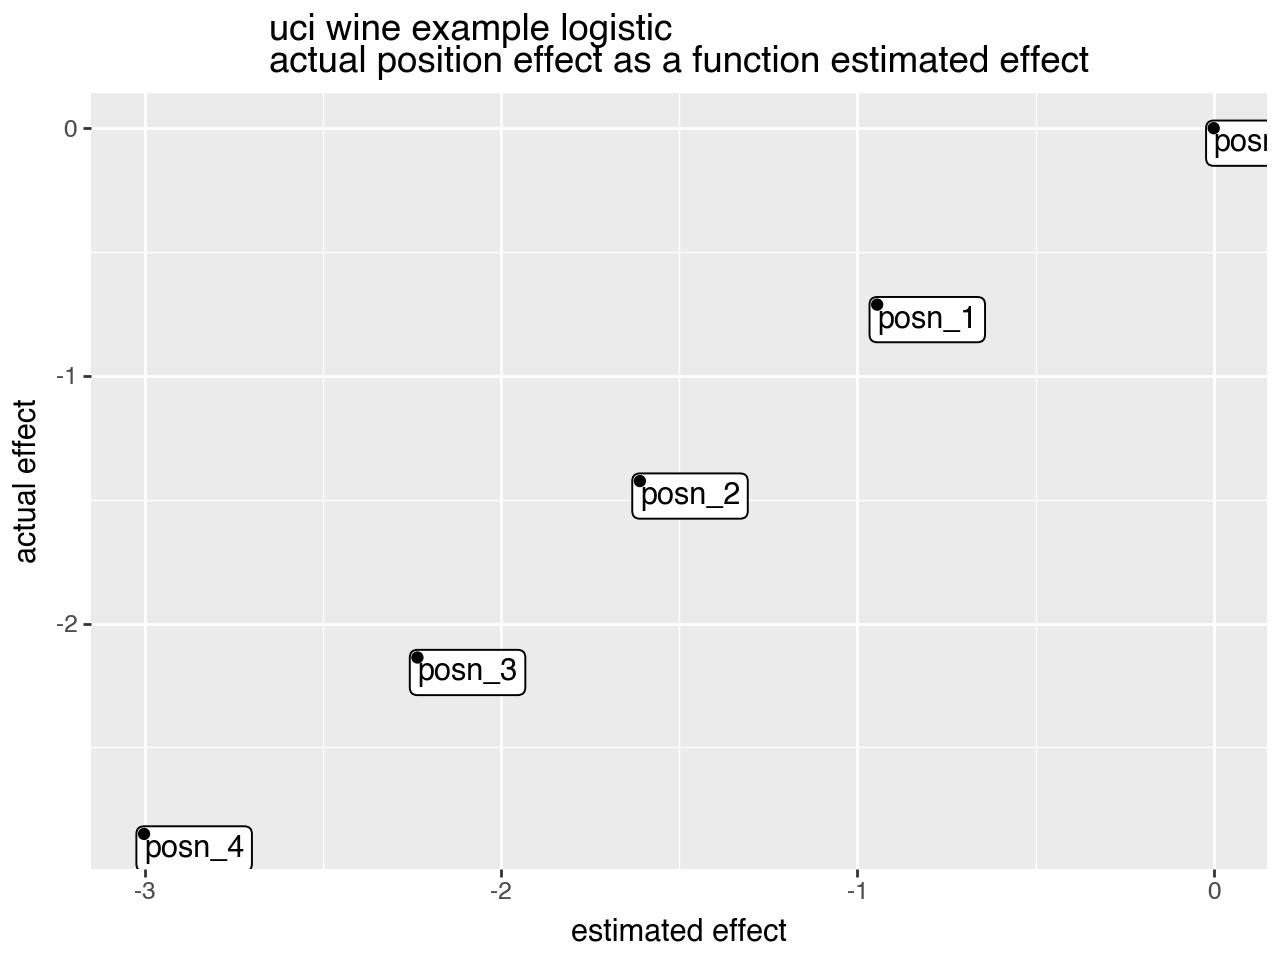

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2658,True
1,0,1,0.2014,False
2,0,2,0.1831,False
3,0,3,0.1918,False
4,0,4,0.1579,False
5,1,0,0.2551,False
6,1,1,0.2496,True
7,1,2,0.1867,False
8,1,3,0.1733,False
9,1,4,0.1353,False


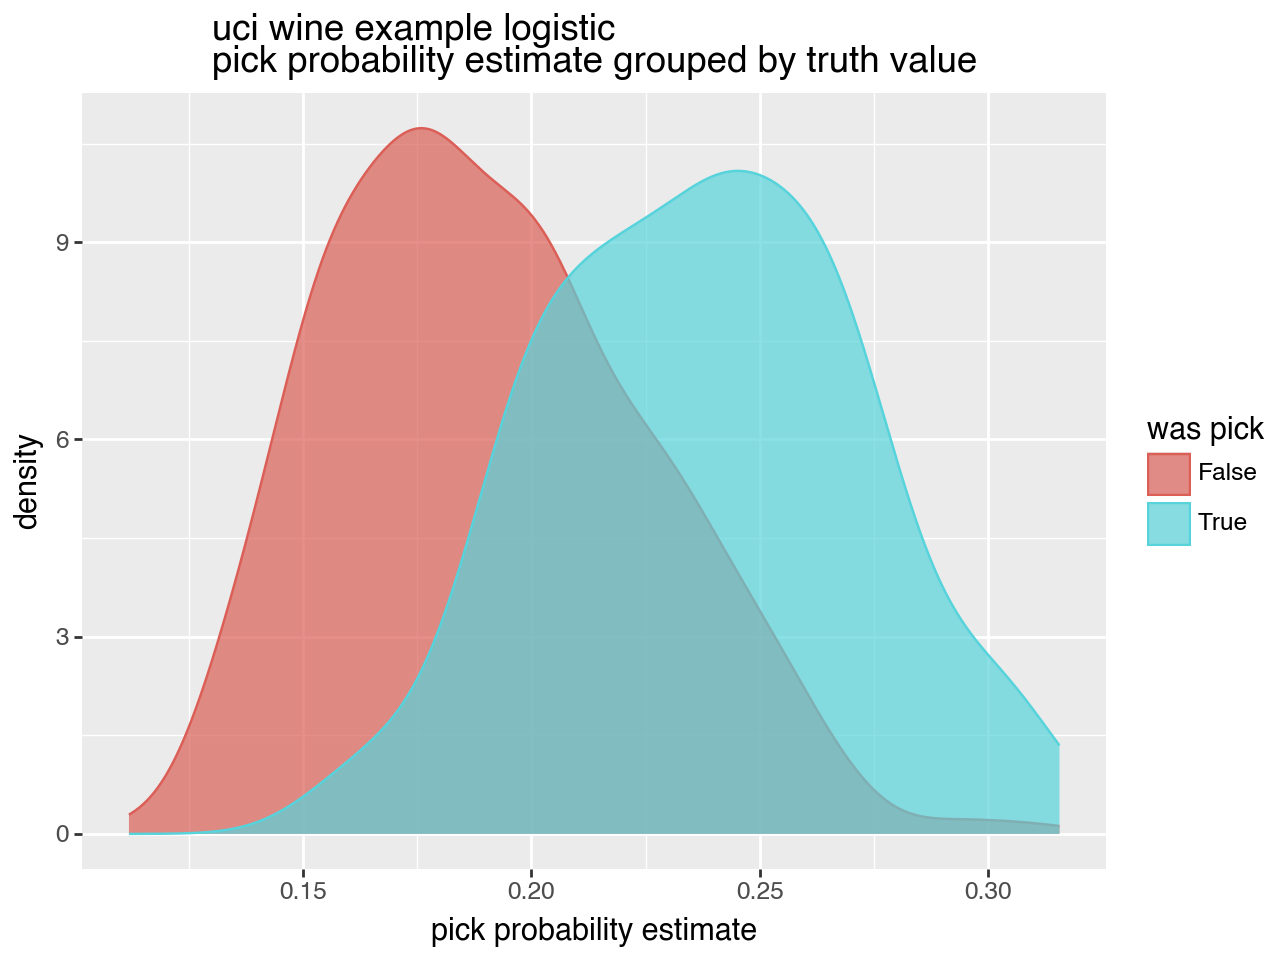

<Figure size 640x480 with 0 Axes>

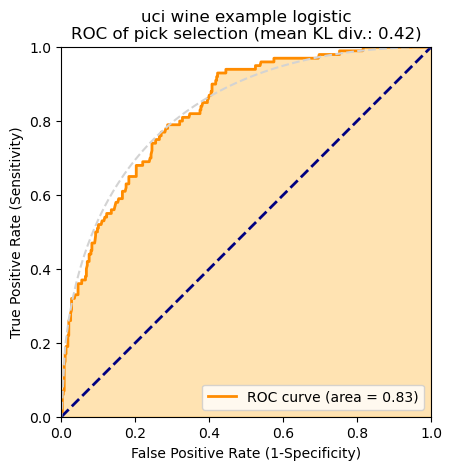

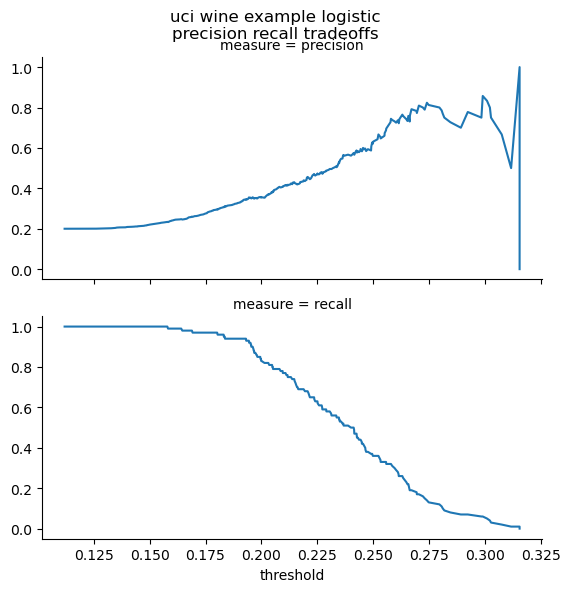

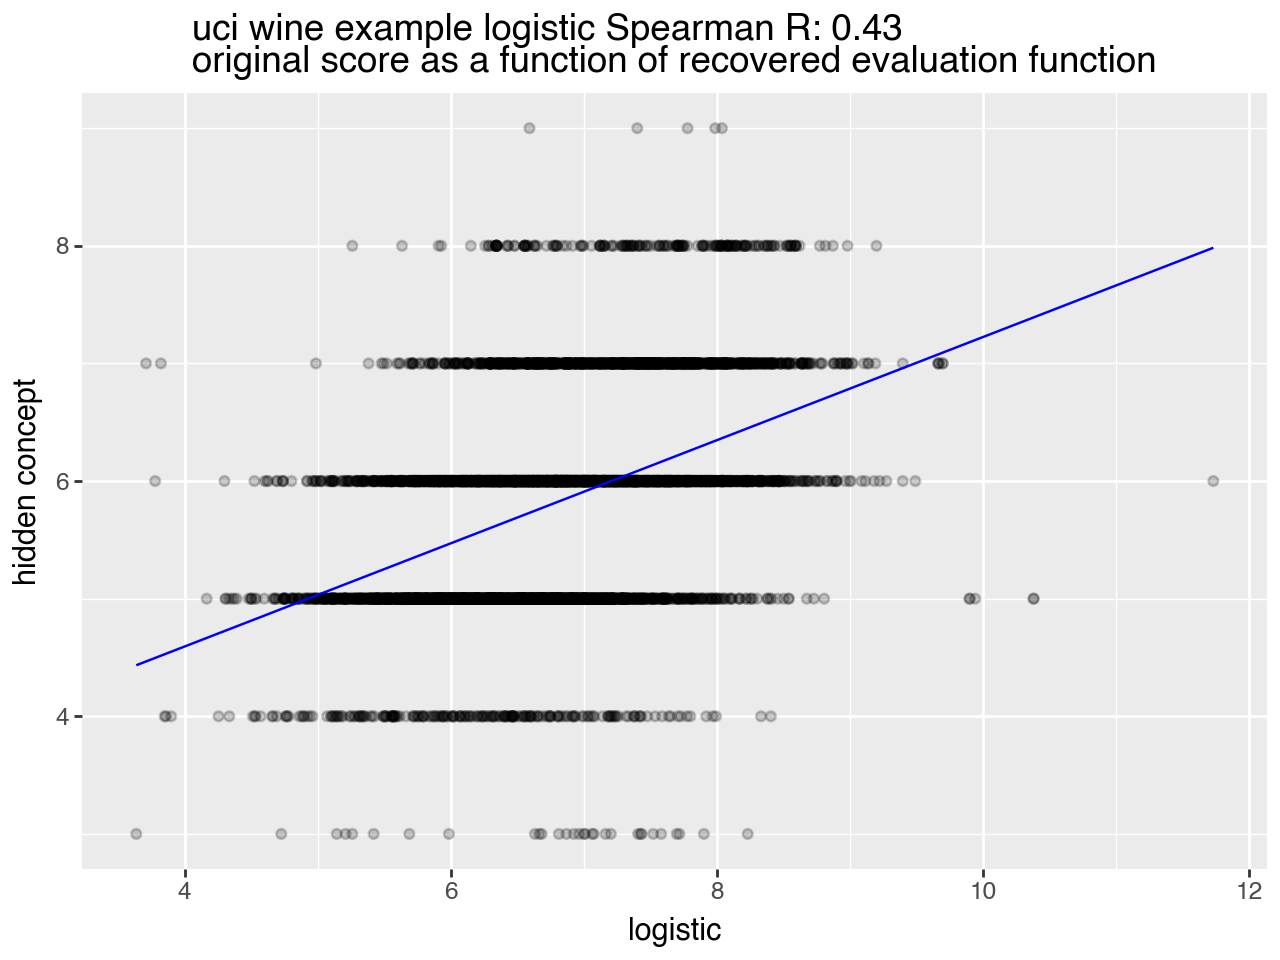

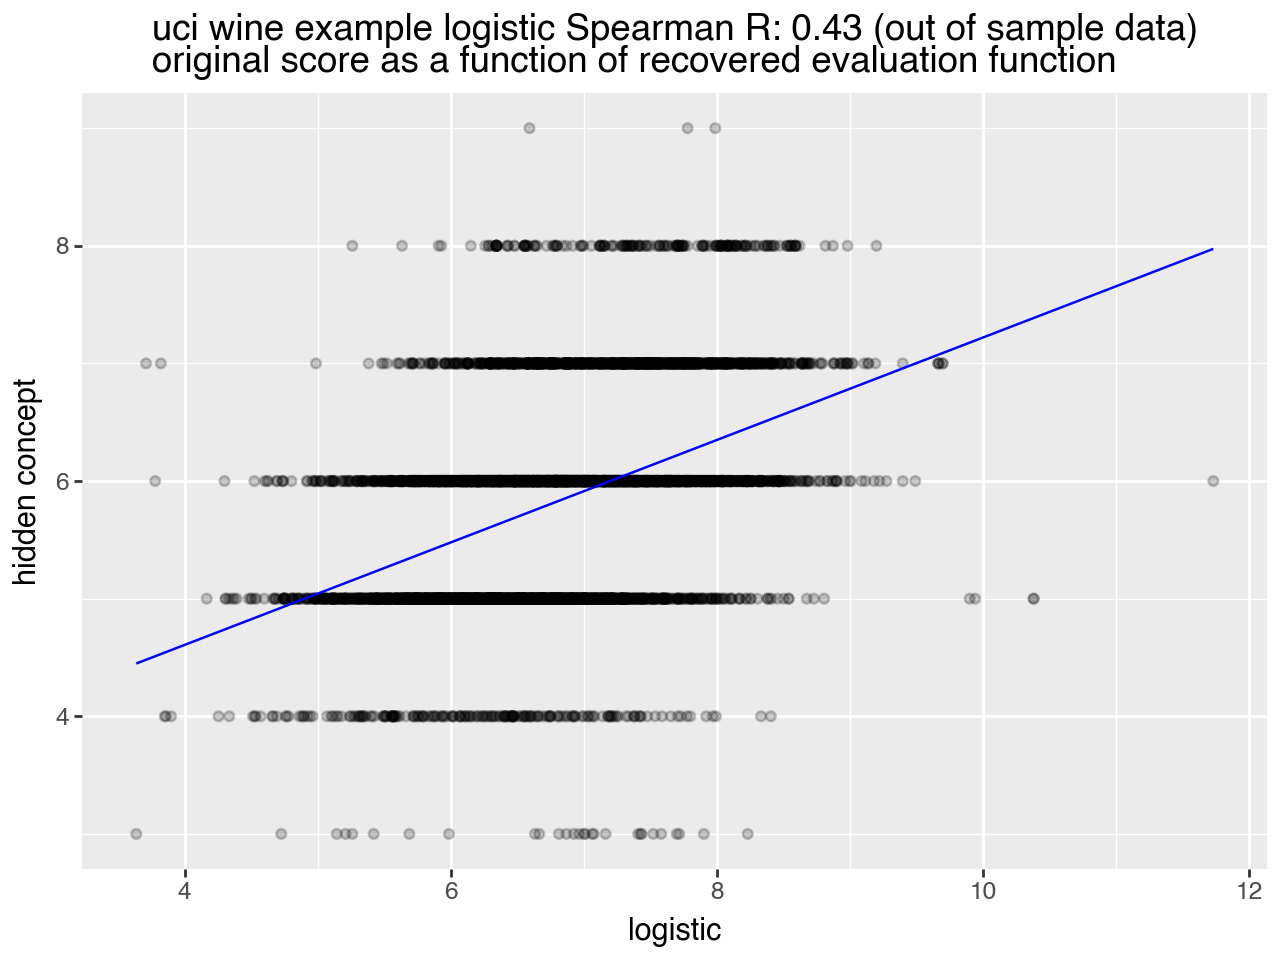

In [35]:
stat_pull = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classificaton_model_name,  # display name of estimate
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can also try a related Stan model per-comparison, instead of per-panel.

In [36]:
stan_model_comparison_src = define_Stan_choice_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_comparison_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  expect_passed_1 = x_passed_1 * beta;      // modeled expected score of passed item
  expe

In [37]:
fit_comp = run_stan_model(
    stan_model_src=stan_model_comparison_src,
    data_str=data_str,
)

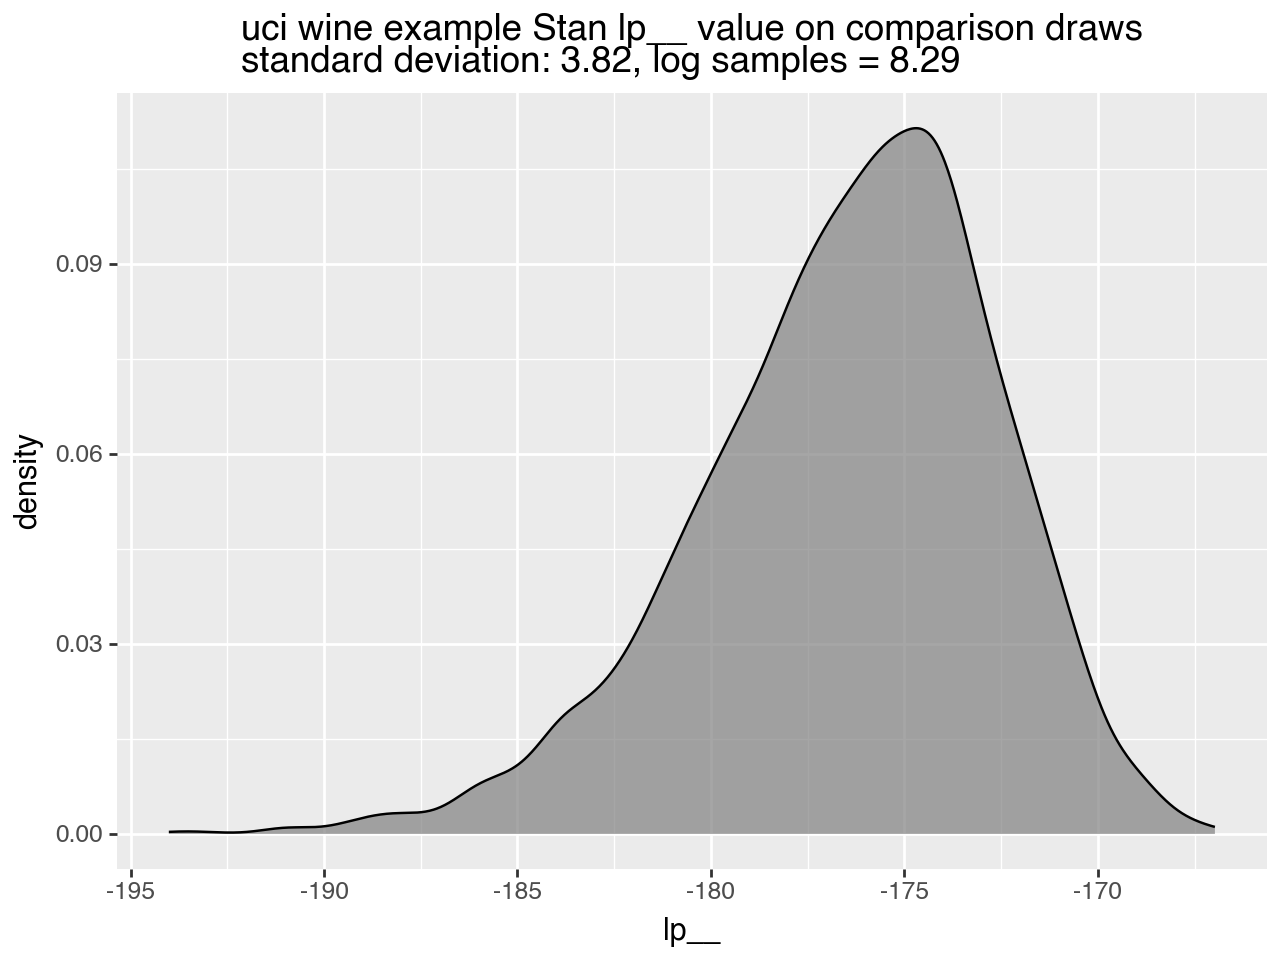

In [38]:
# get implied sample weights from chain
wt_frame_c = fit_comp.draws_pd(vars=["lp__"])
if do_display:
    stddev_c = np.sqrt(np.var(wt_frame_c["lp__"]))
    log_samples_c = np.log(wt_frame_c.shape[0])
    (
        ggplot(
            data=wt_frame_c,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on comparison draws\nstandard deviation: {stddev_c:.2f}, log samples = {log_samples_c:.2f}"
        )
    ).show()

In [39]:
beta_draws_c = fit_comp.draws_pd(vars=["beta"])
estimated_beta_Stan_c = beta_draws_c.loc[
    wt_frame_c["lp__"] >= np.quantile(wt_frame_c["lp__"], 0.5), :
].mean()
# estimated_beta_Stan_c = beta_draws_c.mean()

estimated position influences


,position,estimated effect,actual effect
0,posn_0,0.000000,-0.0000
1,posn_1,-7.818640,-0.7123
2,posn_2,-13.621343,-1.4246
3,posn_3,-18.859510,-2.1369
4,posn_4,-25.690788,-2.8492


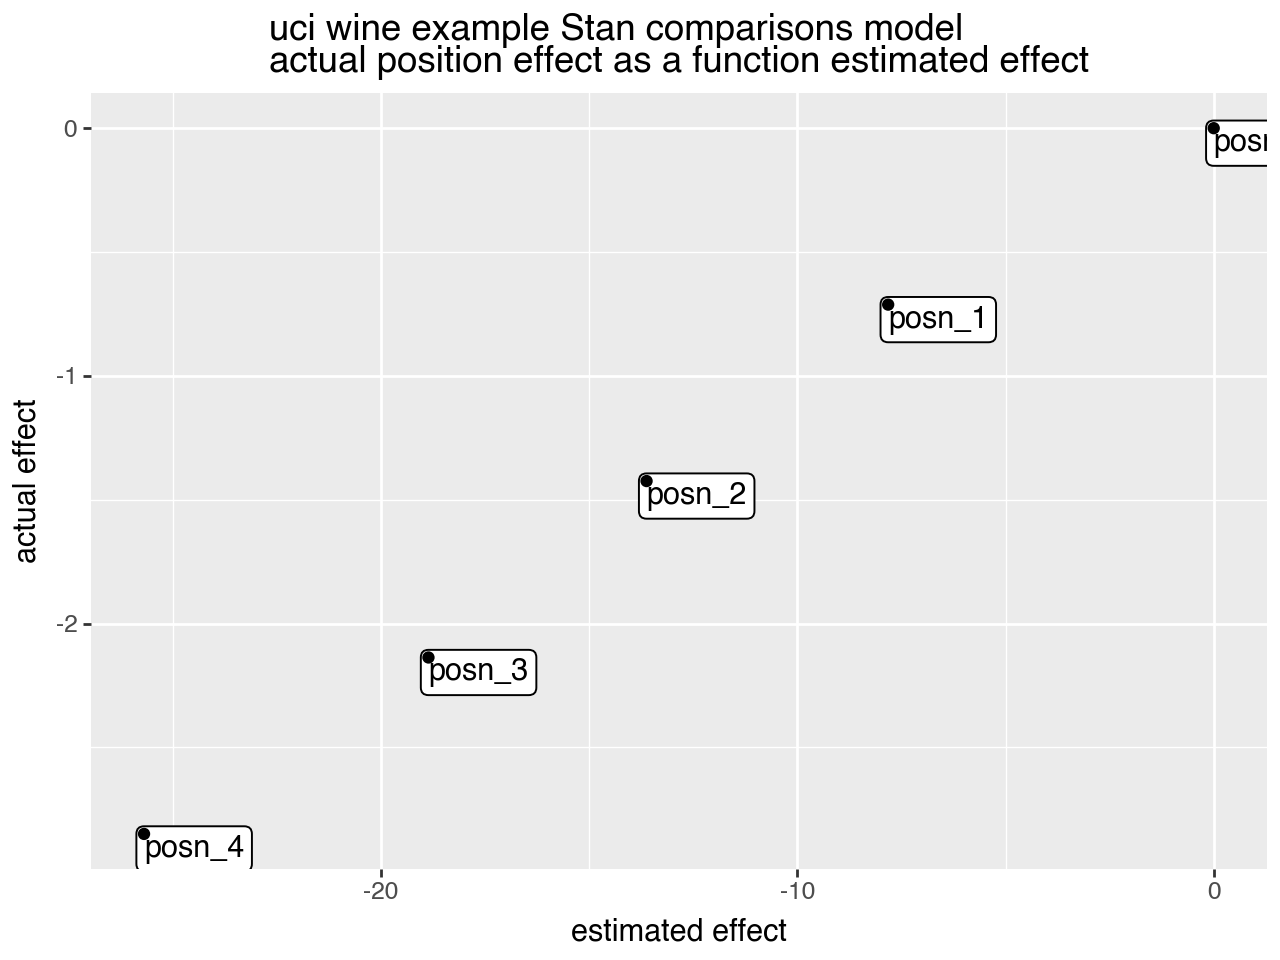

picks


,row,position,pick probability estimate,was pick
0,0,0,0.7838,True
1,0,1,0.1011,False
2,0,2,0.0345,False
3,0,3,0.0730,False
4,0,4,0.0076,False
5,1,0,0.4703,False
6,1,1,0.4896,True
7,1,2,0.0259,False
8,1,3,0.0136,False
9,1,4,0.0006,False


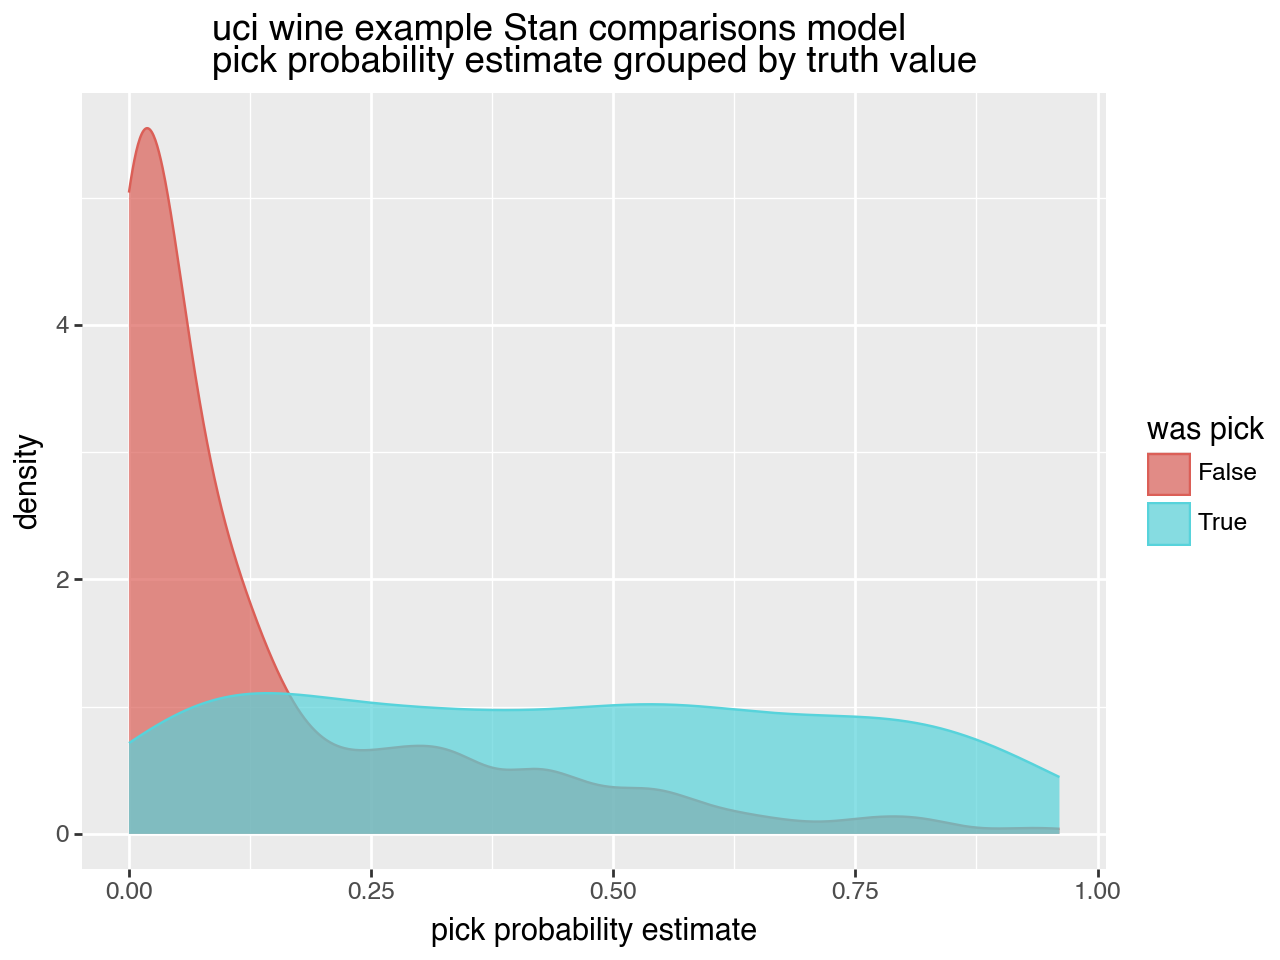

<Figure size 640x480 with 0 Axes>

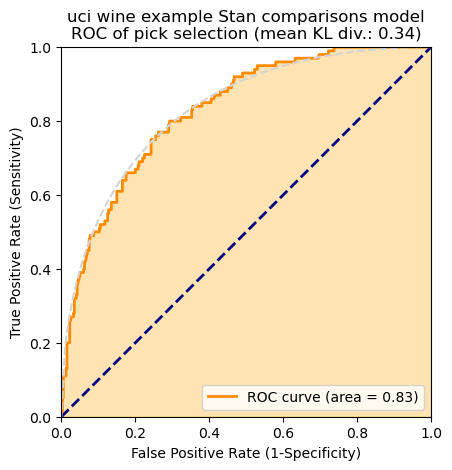

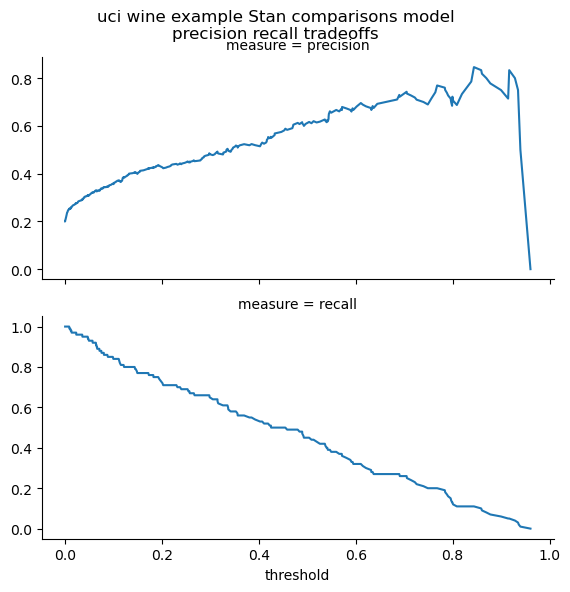

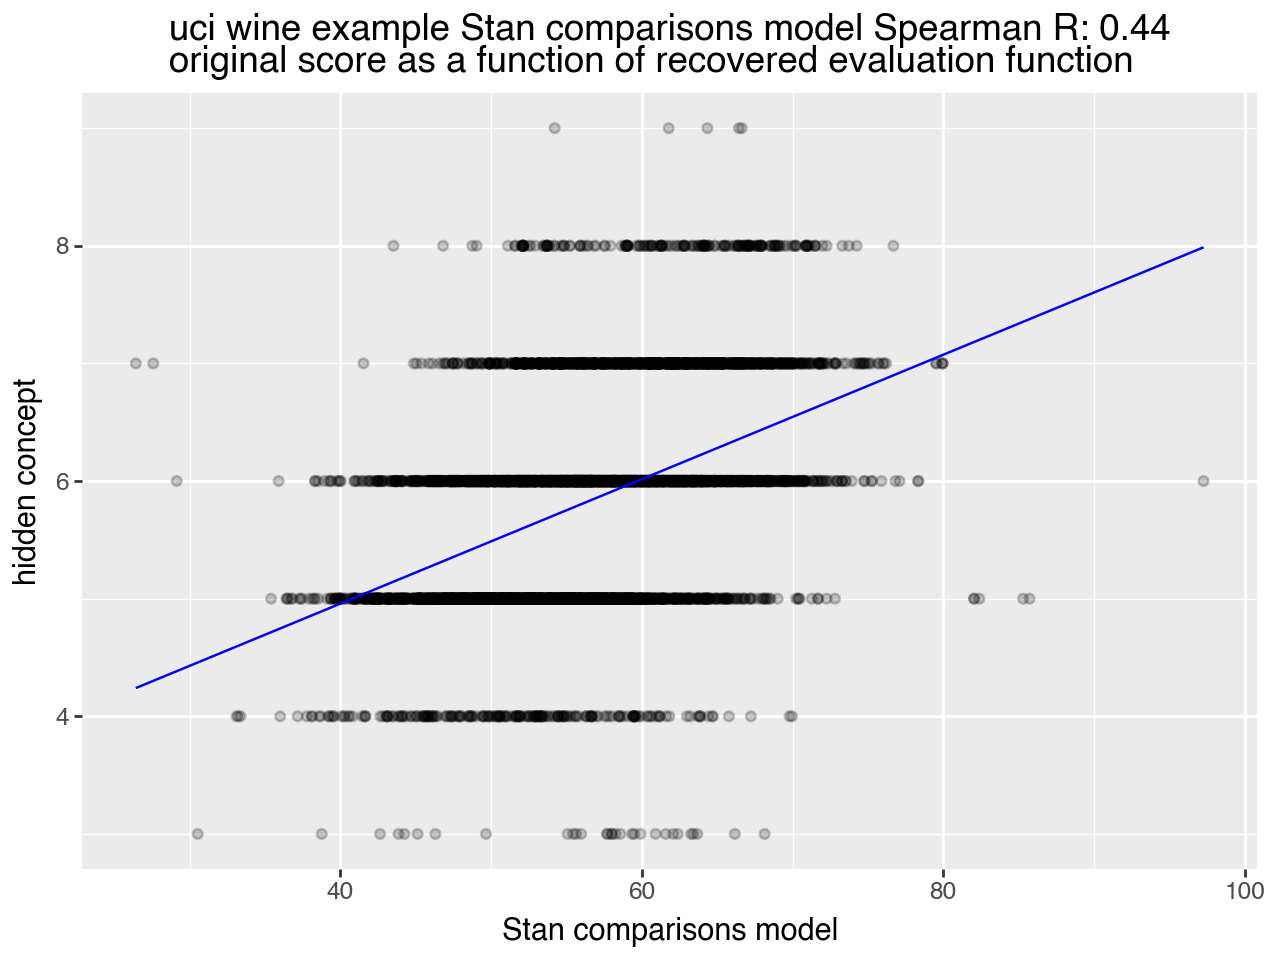

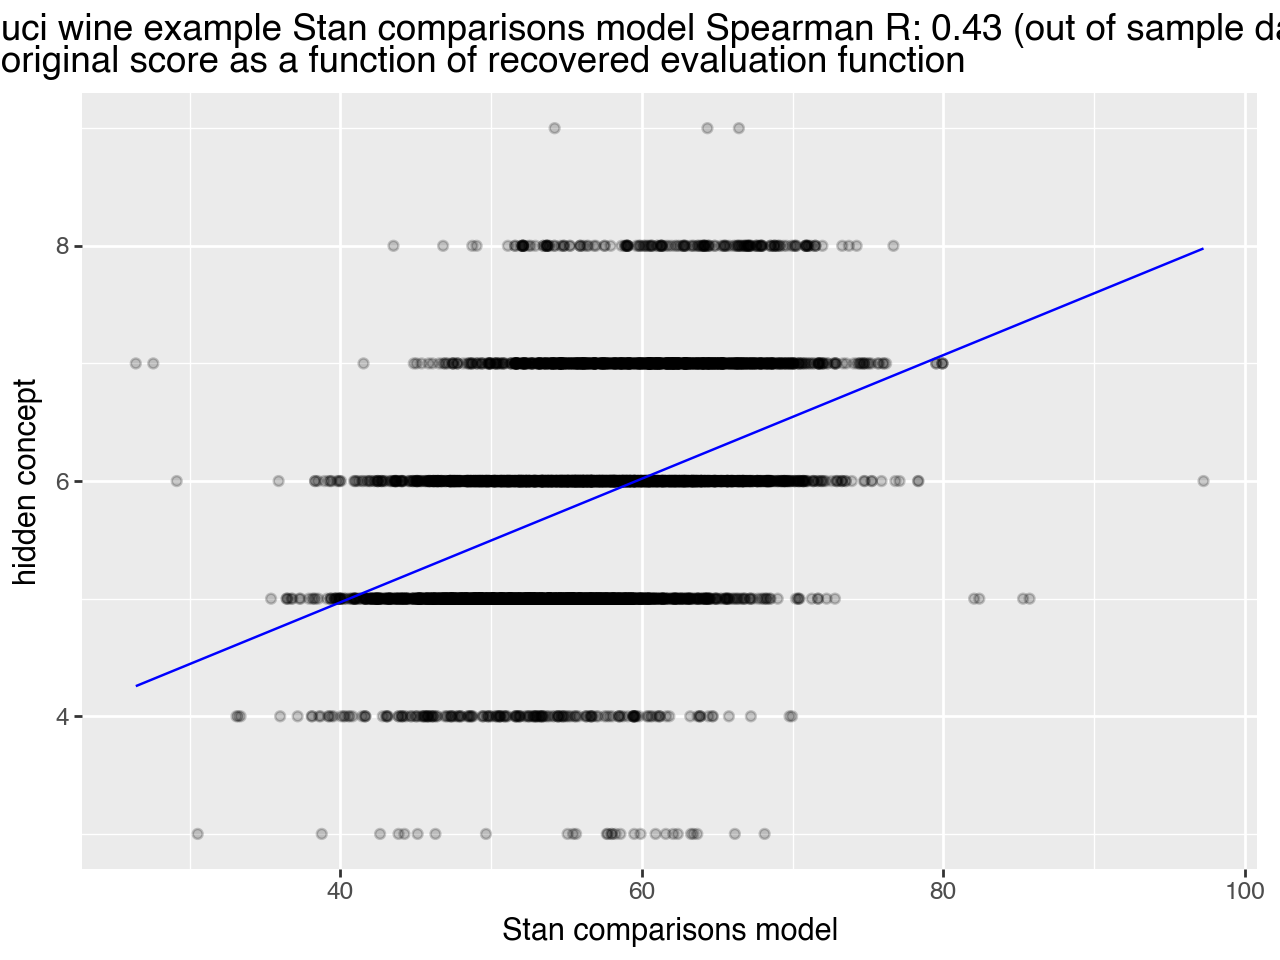

In [40]:
stat_pull = plot_rank_performance(
    model=estimated_beta_Stan_c,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan comparisons model",  # display name of estimate
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

estimated position influences


,position,estimated effect,actual effect
0,posn_0,0.000000,-0.0000
1,posn_1,-0.571720,-0.7123
2,posn_2,-1.151495,-1.4246
3,posn_3,-2.072031,-2.1369
4,posn_4,-2.874624,-2.8492


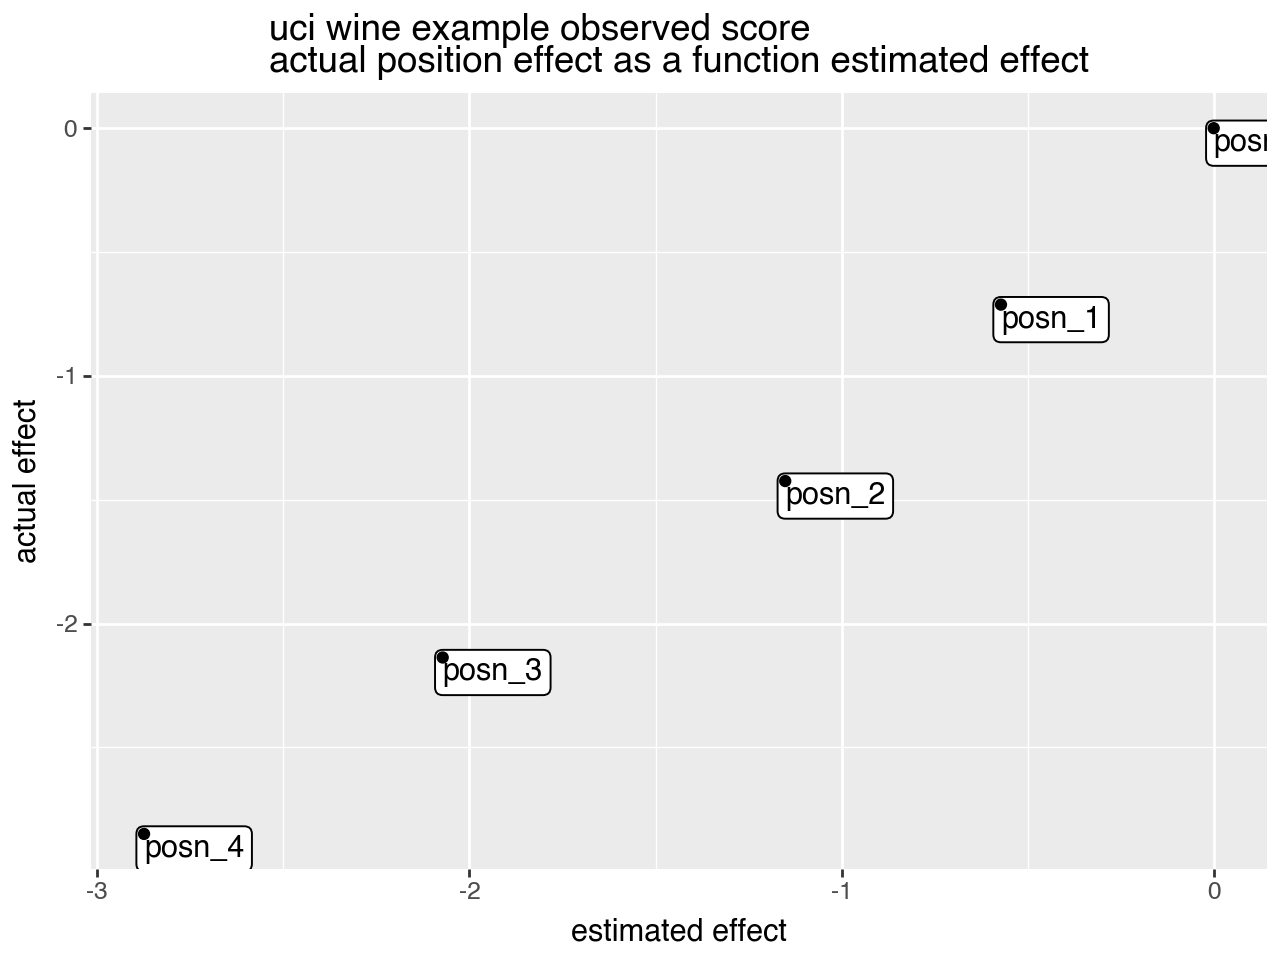

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2477,True
1,0,1,0.2095,False
2,0,2,0.2015,False
3,0,3,0.1851,False
4,0,4,0.1562,False
5,1,0,0.2447,False
6,1,1,0.2570,True
7,1,2,0.2011,False
8,1,3,0.1508,False
9,1,4,0.1464,False


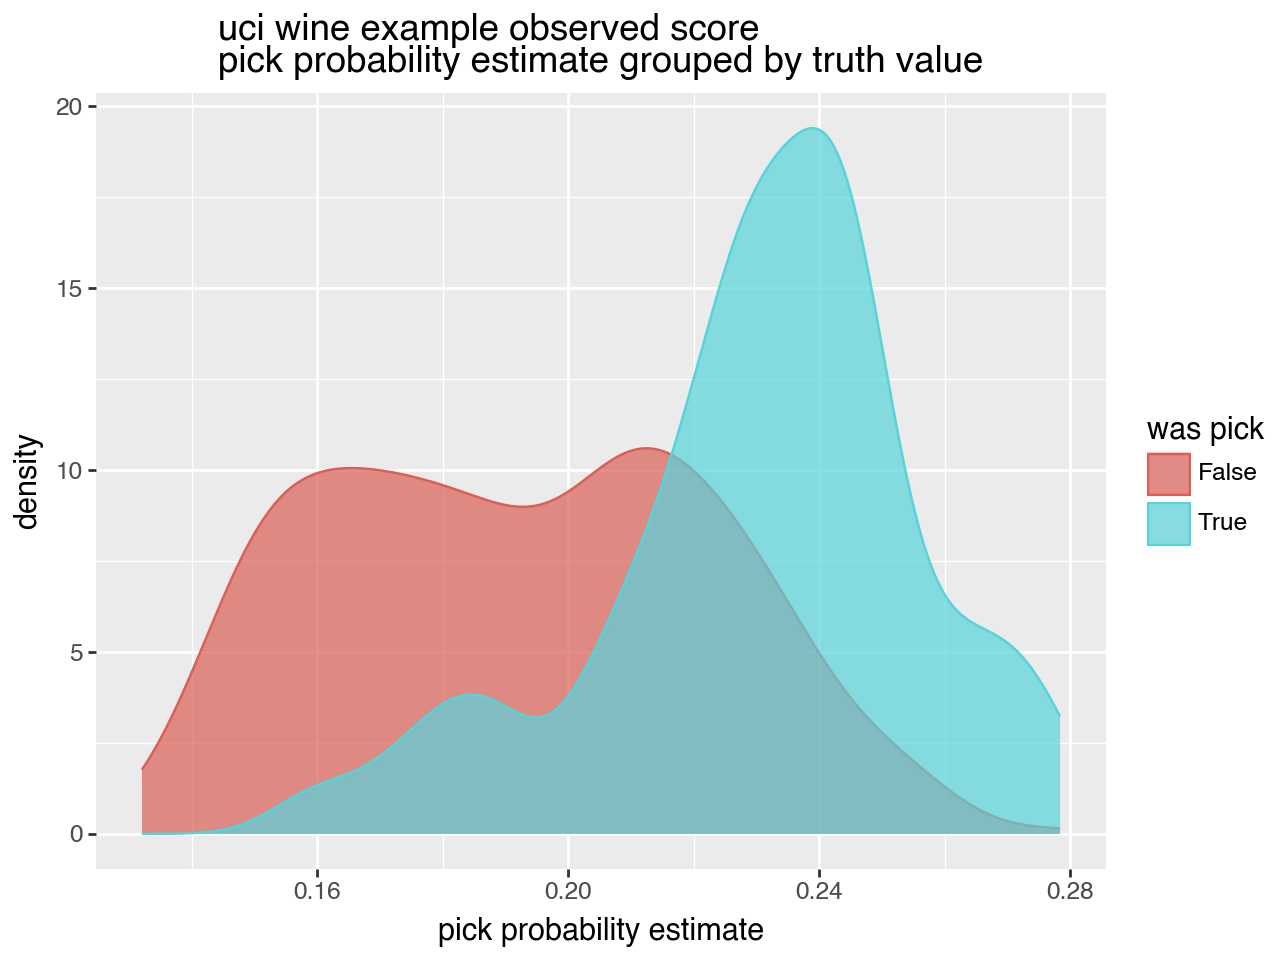

<Figure size 640x480 with 0 Axes>

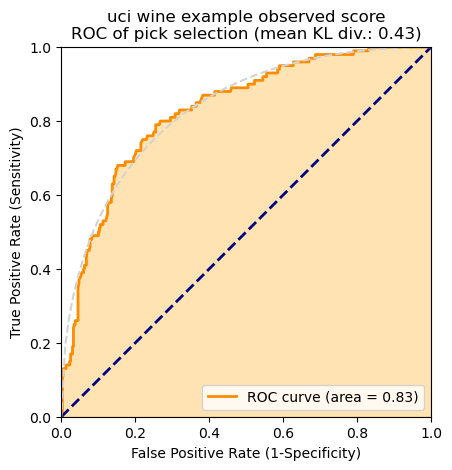

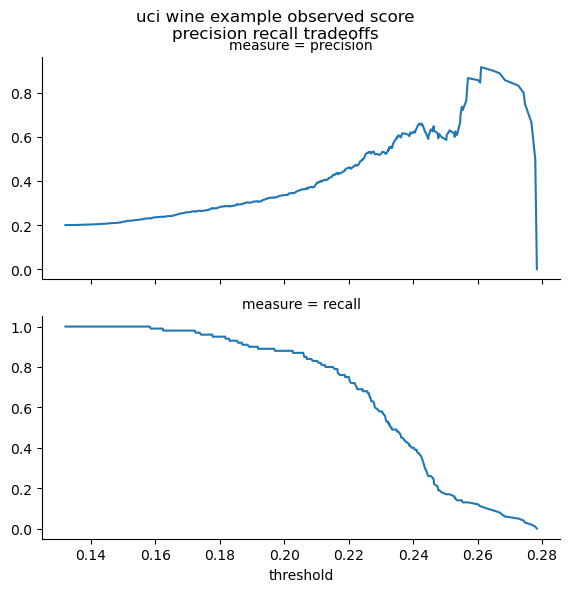

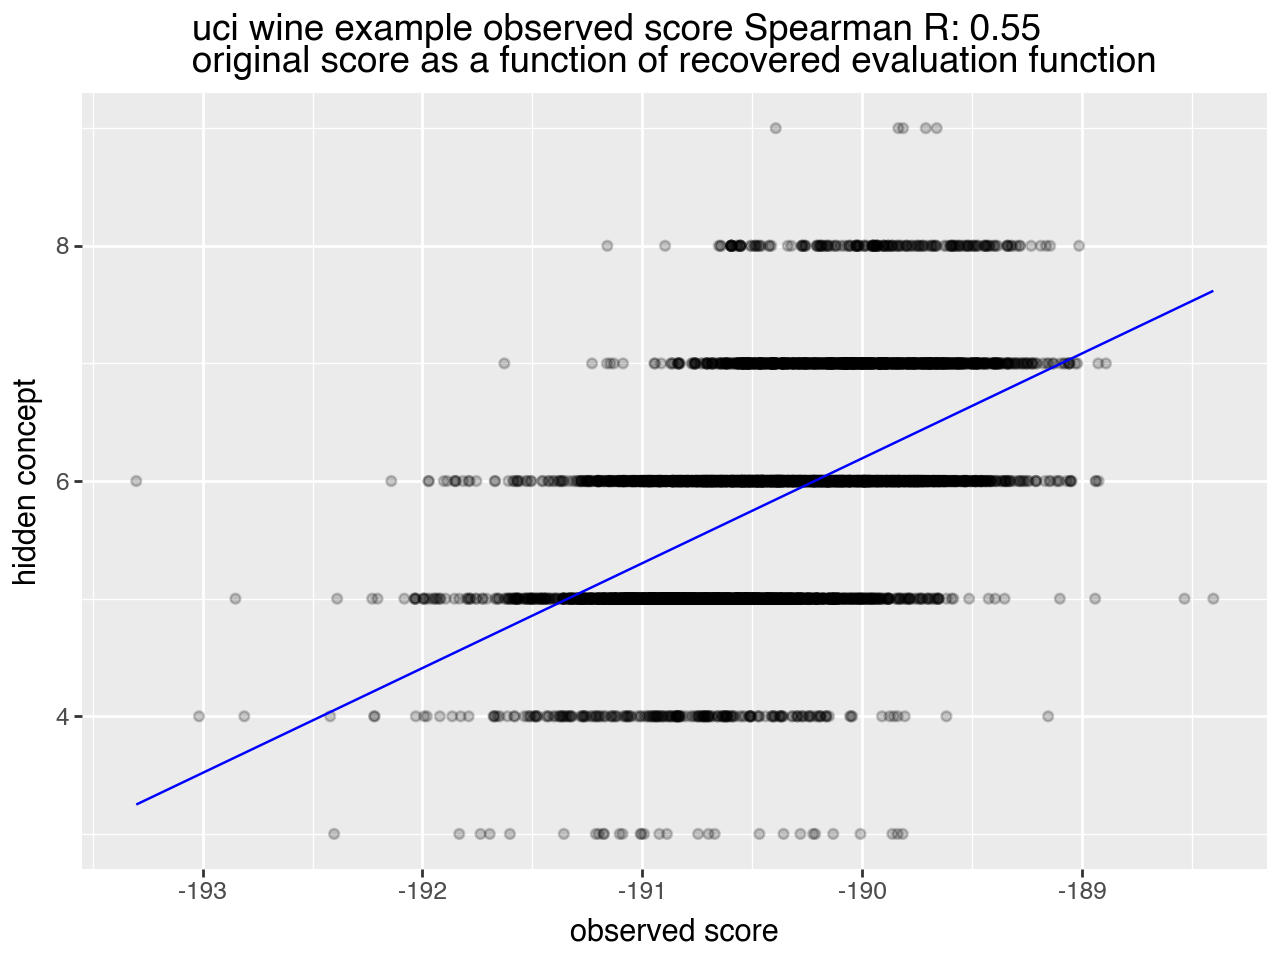

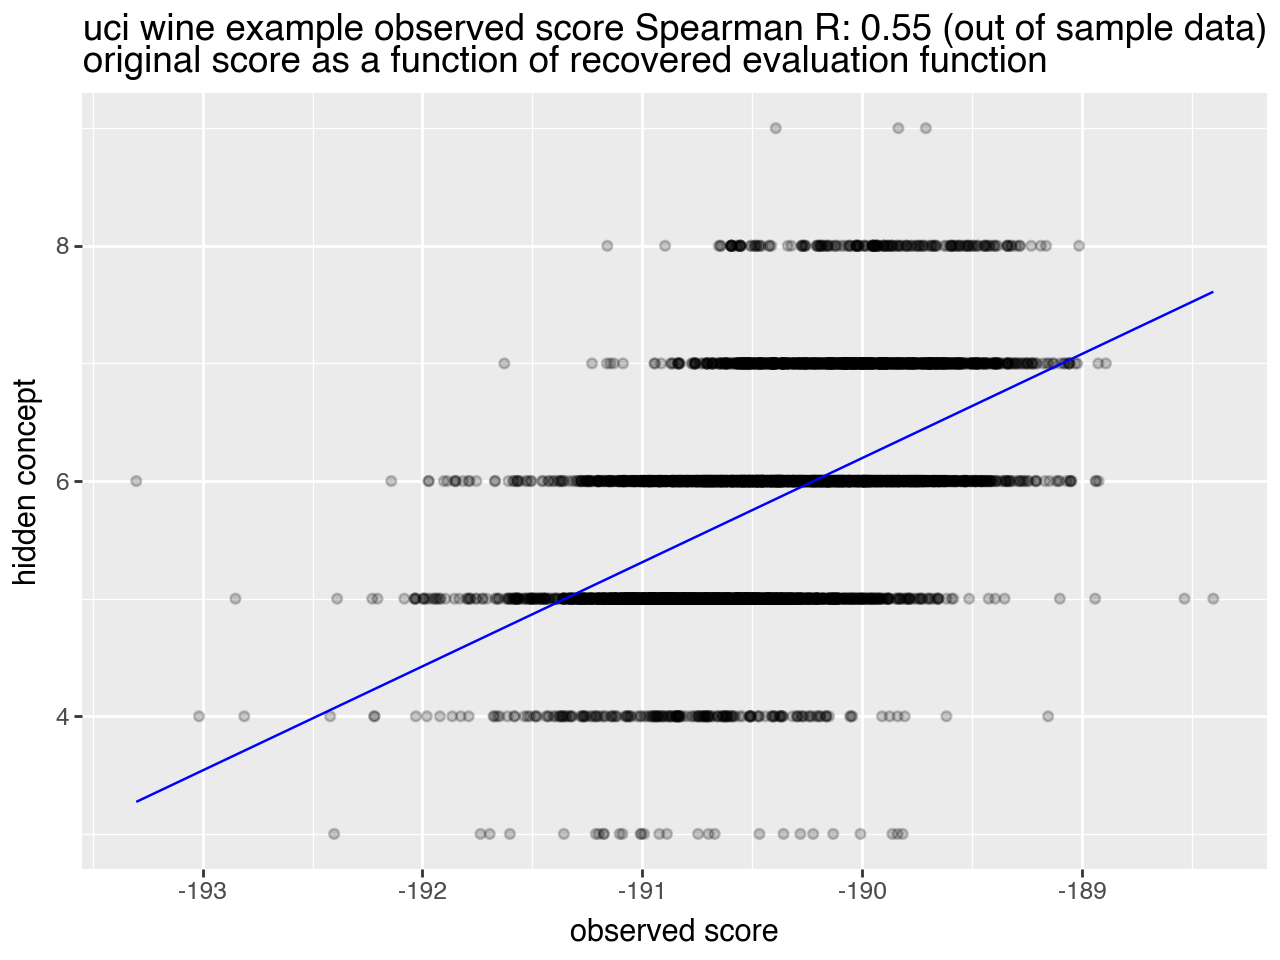

In [41]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        position_penalties=position_penalties,  # ideal position penalties
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [42]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [43]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [44]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size
0,uci wine example,Stan panel model,0.429034,0.426062,0.822437,0.336486,100,100,6497,6013
1,uci wine example,logistic,0.434607,0.431649,0.830313,0.417672,100,100,6497,6013
2,uci wine example,Stan comparisons model,0.437369,0.434302,0.829512,0.340895,100,100,6497,6013
3,uci wine example,observed score,0.551482,0.549029,0.829688,0.425096,100,100,6497,6013
